# 0. Preparação

In [ ]:
# resolving modules
import Pkg
Pkg.add("CSV")
Pkg.add("MLJ")
Pkg.add("Flux")
Pkg.add("MLJBase")
Pkg.add("StatsPlots")
Pkg.add("MLJModels")
Pkg.add("DataFrames")
Pkg.add("ScikitLearn")
Pkg.add("CategoricalArrays")
Pkg.add("MLJLIBSVMInterface")
Pkg.add("MLJScikitLearnInterface")
Pkg.add("StatisticalMeasures")

In [2]:
using DataFrames
using CSV
using MLJ, MLJModels, MLJBase
using CategoricalArrays
import ScikitLearn

In [3]:
train_df = CSV.read("./data/train.csv", DataFrame)
display(describe(train_df))

size(train_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,PassengerId,446.0,1,446.0,891,0,Int64
2,Survived,0.383838,0,0.0,1,0,Int64
3,Pclass,2.30864,1,3.0,3,0,Int64
4,Name,,"Abbing, Mr. Anthony",,"van Melkebeke, Mr. Philemon",0,String
5,Sex,,female,,male,0,String7
6,Age,29.6991,0.42,28.0,80.0,177,"Union{Missing, Float64}"
7,SibSp,0.523008,0,0.0,8,0,Int64
8,Parch,0.381594,0,0.0,6,0,Int64
9,Ticket,,110152,,WE/P 5735,0,String31


(891, 12)

# 1. Tratamento de dados

In [4]:
# coluna embarked possui poucas linhas nulas -> retiradas
# coluna age tem uma quantidade ok de linhas nulas -> trocar pela mediana
# coluna cabin tem muitas linhas nulas -> ignorar a coluna
train_df = dropmissing(train_df, "Embarked")
train_df.Age = replace(train_df.Age, missing => 28)
train_df = DataFrames.select(train_df, Not("Cabin"))

# passenger ID e nome são apenas identificadores e não ajudam a classificar
train_df = DataFrames.select(train_df, Not(["PassengerId", "Name"]))

describe(train_df)


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Survived,0.382452,0,0.0,1,0,Int64
2,Pclass,2.31159,1,3.0,3,0,Int64
3,Sex,,female,,male,0,String7
4,Age,29.3152,0.42,28.0,80.0,0,Float64
5,SibSp,0.524184,0,0.0,8,0,Int64
6,Parch,0.382452,0,0.0,6,0,Int64
7,Ticket,,110152,,WE/P 5735,0,String31
8,Fare,32.0967,0.0,14.4542,512.329,0,Float64
9,Embarked,,C,,S,0,String1


In [5]:
# verificando valores únicos de cada coluna não-numérica
combine(groupby(train_df,"Sex"), nrow=>"count")

Row,Sex,count
,String7,Int64
1,male,577
2,female,312


In [6]:
combine(groupby(train_df,"Ticket"), nrow=>"count")

Row,Ticket,count
,String31,Int64
1,A/5 21171,1
2,PC 17599,1
3,STON/O2. 3101282,1
4,113803,2
5,373450,1
6,330877,1
7,17463,1
8,349909,4
9,347742,3


In [7]:
combine(groupby(train_df,"Embarked"), nrow=>"count")

Row,Embarked,count
,String1,Int64
1,S,644
2,C,168
3,Q,77


In [8]:
# para Sex e Embarked, é possível codificar para numeros.
# para Ticket, são muitos valores únicos -> ignorar coluna

train_df.Sex = Int64.(replace(train_df.Sex, "female" => 1, "male" => 2))
train_df.Embarked = Int64.(replace(train_df.Embarked, "S" => 1, "C" => 2, "Q" => 3))

train_df = DataFrames.select(train_df, Not("Ticket"))
describe(train_df) # dataset limpo!

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Survived,0.382452,0,0.0,1,0,Int64
2,Pclass,2.31159,1,3.0,3,0,Int64
3,Sex,1.64904,1,2.0,2,0,Int64
4,Age,29.3152,0.42,28.0,80.0,0,Float64
5,SibSp,0.524184,0,0.0,8,0,Int64
6,Parch,0.382452,0,0.0,6,0,Int64
7,Fare,32.0967,0.0,14.4542,512.329,0,Float64
8,Embarked,1.3622,1,1.0,3,0,Int64


# 2. Criação e Treinamento dos Modelos (SVC e KNN)

In [9]:
X_train = DataFrames.select(train_df, Not(:Survived))
X_train = coerce(X_train, :Pclass => Continuous, :Sex => Continuous, :SibSp => Continuous, :Parch => Continuous, :Embarked => Continuous)
y_train = train_df.Survived

889-element Vector{Int64}:
 0
 1
 1
 1
 0
 0
 0
 0
 1
 1
 ⋮
 0
 0
 0
 0
 0
 1
 0
 1
 0

In [10]:
# Carregar os modelos
SVC = @load SVC pkg="LIBSVM"
KNN = @load KNeighborsClassifier pkg="MLJScikitLearnInterface"

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\Hecae\.julia\packages\MLJModels\ziReN\src\loading.jl:159


import MLJLIBSVMInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\Hecae\.julia\packages\MLJModels\ziReN\src\loading.jl:159


import MLJScikitLearnInterface ✔


MLJScikitLearnInterface.KNeighborsClassifier

In [11]:
# Criar os modelos
svc_model = SVC()
knn_model = KNN()

KNeighborsClassifier(
  n_neighbors = 5, 
  weights = "uniform", 
  algorithm = "auto", 
  leaf_size = 30, 
  p = 2, 
  metric = "minkowski", 
  metric_params = nothing, 
  n_jobs = nothing)

In [64]:
# Envolver os dados em um formato utilizável por MLJ
y_train_mlj = categorical(y_train); # variável de saída deve ser categórica

In [14]:
# Treinar os modelos
svc_machine = machine(svc_model, X_train, y_train_mlj)
knn_machine = machine(knn_model, X_train, y_train_mlj)

fit!(svc_machine)
fit!(knn_machine)

┌ Info: Training machine(SVC(kernel = RadialBasis, …), …).
└ @ MLJBase C:\Users\Hecae\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(KNeighborsClassifier(n_neighbors = 5, …), …).
└ @ MLJBase C:\Users\Hecae\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


trained Machine; caches model-specific representations of data
  model: KNeighborsClassifier(n_neighbors = 5, …)
  args: 
    1:	Source @642 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @420 ⏎ AbstractVector{Multiclass{2}}


Testar e Avaliar os Modelos

In [66]:
using MLJBase

# Previsões
svc_predictions = predict(svc_machine, X_train) # já vem como um vetor categórico
knn_predictions_labels = mode.(knn_predictions) # transforma para um vetor categórico
knn_predictions = predict(knn_machine, X_train); 

In [ ]:
using CategoricalArrays
using StatisticalMeasures

#instancia os calculadores
acc = Accuracy()
prec = PositivePredictiveValue()
rec = TruePositiveRate()
f1 = FScore()

# Avaliação do modelo SVC
svc_accuracy = acc(svc_predictions, y_train_mlj)
svc_precision = prec(svc_predictions, y_train_mlj)
svc_recall = rec(svc_predictions, y_train_mlj)
svc_f1_score = f1(svc_predictions, y_train_mlj)


# Avaliação do modelo KNN
knn_accuracy = acc(knn_predictions_labels, y_train_mlj)
knn_precision = prec(knn_predictions_labels, y_train_mlj)
knn_recall = rec(knn_predictions_labels, y_train_mlj)
knn_f1 = f1(knn_predictions_labels, y_train_mlj)

In [38]:

# Apresentação dos resultados
println("-------- Desempenho do modelo SVC -------- ")
println("Acurácia: ", svc_accuracy)
println("Precisão: ", svc_precision)
println("Recall: ", svc_recall)
println("F1-Score: ", svc_f1_score)

println("\n-------- Desempenho do modelo KNN: --------")
println("Acurácia: ", knn_accuracy)
println("Precisão: ", knn_precision)
println("Recall: ", knn_recall)
println("F1-Score: ", knn_f1)

-------- Desempenho do modelo SVC -------- 
Acurácia: 0.6850393700787402
Precisão: 0.7027027027027026
Recall: 0.3058823529411765
F1-Score: 0.4262295081967213

-------- Desempenho do modelo KNN: --------
Acurácia: 0.8020247469066367
Precisão: 0.7789115646258503
Recall: 0.6735294117647059
F1-Score: 0.722397476340694


# 3. Visualização

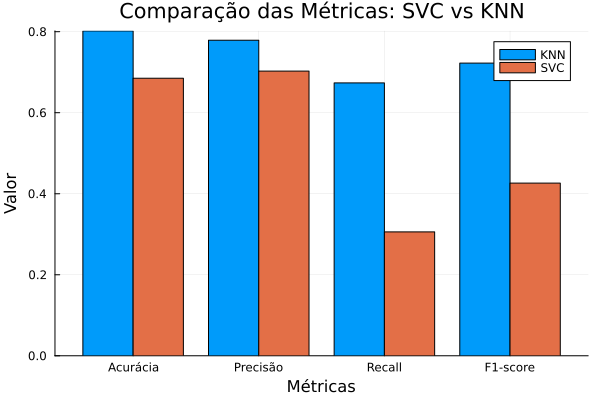

In [63]:
using StatsPlots

# Métricas para cada modelo (substitua pelos seus valores reais)
metrics_svc = [svc_accuracy, svc_precision, svc_recall, svc_f1_score]
metrics_knn = [knn_accuracy, knn_precision, knn_recall, knn_f1]

metric_names = ["Acurácia", "Precisão", "Recall", "F1-score"]


groupedbar(metric_names, [metrics_knn metrics_svc], label=["KNN" "SVC"], bar_position=:dodge)

# Título e eixos
title!("Comparação das Métricas: SVC vs KNN")
xlabel!("Métricas")
ylabel!("Valor")